# Understanding whole-slide images:

This first hands-on session will guide you to learn how to visualize and manipulate giga-pixel whole-slide images (WSIs).


## Qupath  

![](https://github.com/guillaumejaume/mil-tutorial/blob/main/support/wsi_example.png?raw=true)

We will be using QuPath, an open-source software that allows visualizing, annotating bounding boxes, and extracting information from WSIs.

When building a computational pathology pipeline, you will typically need to:
- Assess the image quality: ensure staining quality, images are not blurred, or have ink stains
- Validate the quality of the annotations, either at slide-level or regions (boxes or dense pixel annotations)
- understand the type of task/prior that needs to be considered when learning on your images, e.g.,
   - if classifying different tumor subtypes, what is the percentage of the slide that occupies the tumor 
   - if detecting small objects, such as mitosis, what is the appropriate resolution
- Validate the quality of the Deep Learning system on fined-grained annotations

QuPath is the best tool for all these tasks! 

Instructions:

- Download QuPath (https://qupath.readthedocs.io/en/0.4/docs/intro/installation.html#download-install)
   - Support Windows, Mac and Ubuntu 
   - Requires 4GB of RAM (runs smoothly on most modern computers)

Download WSIs from here:

- https://drive.google.com/file/d/1GWtuOLRf6-7C8zCG6b3JdYDPk_C5IS3_/view?usp=sharing
- https://drive.google.com/file/d/1o9Es1qdY15y8q_gsjX3KVkn7HS8amlSF/view?usp=sharing

Using QuPath, play around with the two WSIs:
- a necropsy of a rat liver with presence of a necrotic region
- a TCGA sample of invasive breast cancer (BRCA) 

## OpenSlide 

QuPath is helpful for a quick exploration of a new dataset, make small annotations etc, but it cannot be used in a robust deep learning pipeline. Instead, we can use OpenSlide, an open-source Python package that can open, read, and save WSIs (or typically a small region of the slide). 

OpenSlide is a very small package with a fairly small and neat API (see https://openslide.org/api/python/). It also supports most pyramidal formats, such as tiff, svs, ndpi, mrxs, etc. These formats tyically depends on the scanner used to digitize the slides. 

In [1]:
# Install openslide 
!pip install openslide-python

### Accessing slide properties and reading

In [2]:
# Understand slide properties 

import os
import pandas as pd
from glob import glob
from openslide import OpenSlide
from pprint import pprint
import matplotlib.pyplot as plt

slide_path = os.path.join('data', 'slides', 'necrosis.tiff')
slide = OpenSlide(slide_path)

# Check the image dimensions at the highest resolution (20x here): 
print('Image size is: ', slide.dimensions[0], ' x ', slide.dimensions[1])

# Check the number of pre-extracted levels:
print('Number of levels: ', slide.level_count)

# Check the dimensions of each level:
print('All levels:')
for dims in slide.level_dimensions:
    print('    - (', dims[0], ' x ', dims[1], ')')

# Check slide size 
print(f"file size: {round(os.path.getsize(slide_path) / 1024 ** 2, 2)} MB")

# Optional: Check all slide properties 
# pprint(dict(slide.properties))

Image size is:  61751  x  35769
Number of levels:  3
All levels:
    - ( 61751  x  35769 )
    - ( 15437  x  8942 )
    - ( 3859  x  2235 )
file size: 671.22 MB


![](https://github.com/guillaumejaume/mil-tutorial/blob/main/support/context_resolution.png?raw=true)

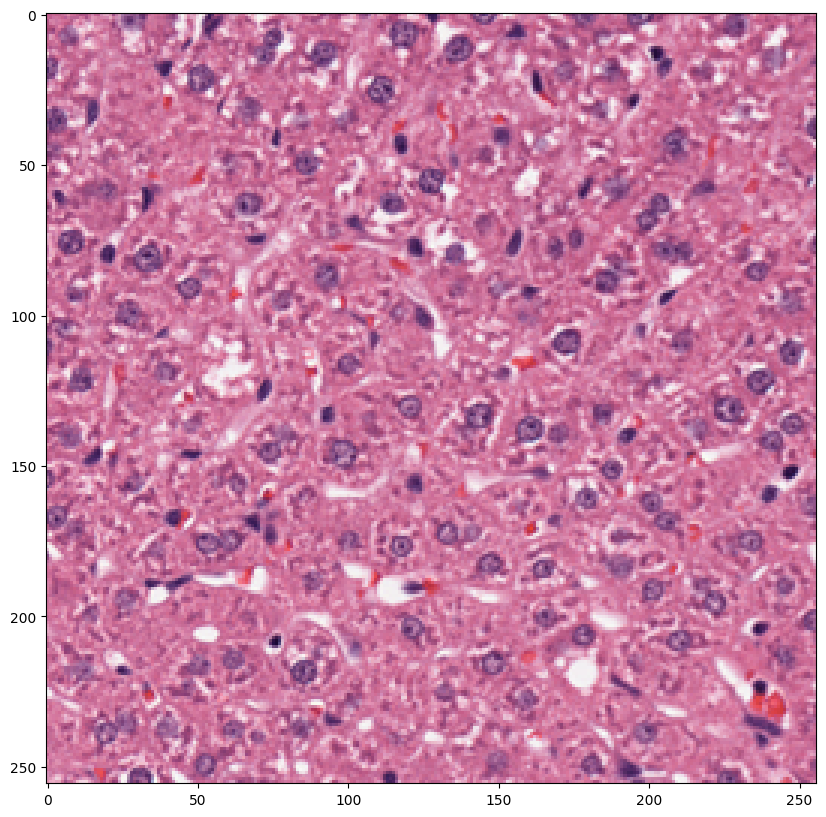

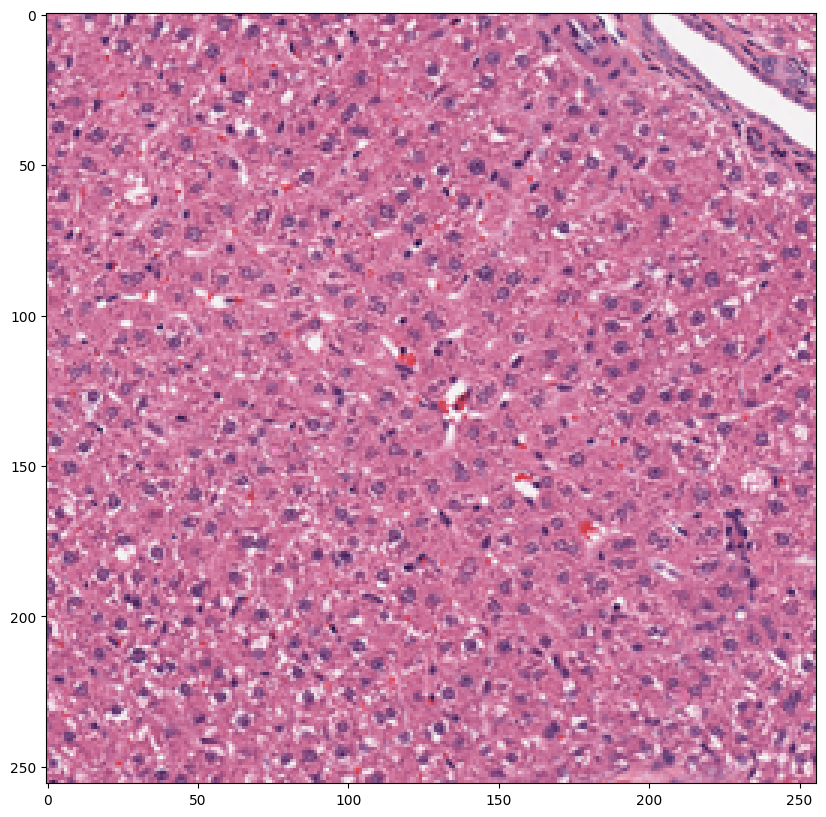

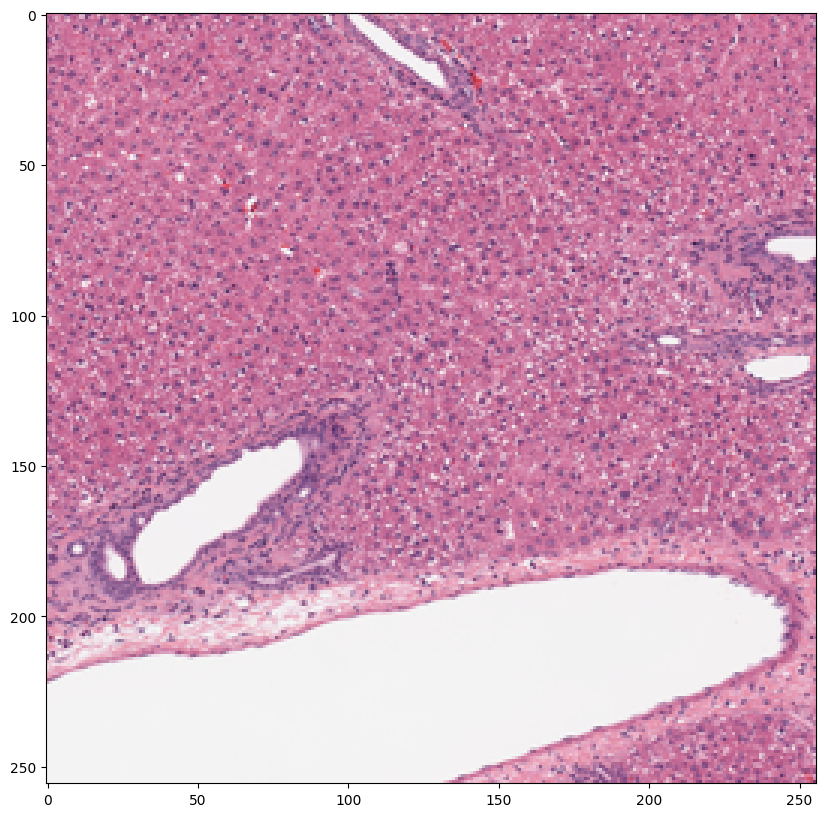

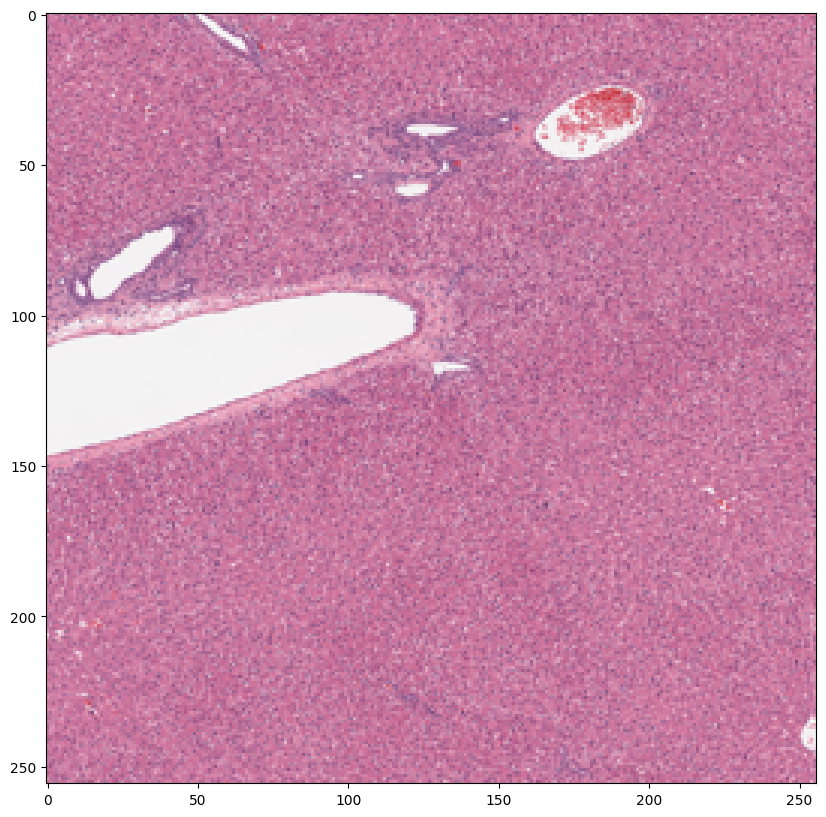

In [3]:
# Extracting and visualizing regions

topleft = (25000, 25000)
size = (256, 256)

for l in range(4):
    size = (size[0] * 2, size[1] * 2)
    region = slide.read_region(topleft, 0, size)
    region = region.resize((256, 256))
    plt.figure(figsize=(10, 10))
    plt.imshow(region)

### Tissue segmentation

![](https://github.com/guillaumejaume/mil-tutorial/blob/main/support/segmentation.png?raw=true)

#### Importance of tissue segmentation: 

- **Removal of Non-Biological Background**: In histopathology images, the tissue of interest is embedded in a background that often contains artifacts, stains, penmarks or other non-biological elements. These elements do not carry any meaningful biological information and can interfere with the accurate analysis of tissue structures. By segmenting and removing the background, computational pathology algorithms can focus solely on the relevant tissue regions, leading to more precise and reliable results.


- **Elimination of Spurious Correlations**: Background regions can introduce spurious correlations in the downstream analysis. If the background is not properly removed, image analysis algorithms may inadvertently assign importance to irrelevant features or patterns present in the background. This can lead to false associations or misleading results, affecting the accuracy and reliability of computational pathology findings. Tissue segmentation helps avoid such spurious correlations by isolating and analyzing only the biologically relevant components.


- **Reduction of Computational Complexity**: Background regions often contribute to the overall complexity of image analysis algorithms without providing any meaningful information. Including these regions in computational processes unnecessarily increases the computational burden and time required for analysis. By segmenting and removing the background, the computational complexity can be significantly reduced, allowing for more efficient and streamlined analysis workflows. This optimization is particularly valuable in large-scale studies or applications that require processing a vast number of histopathology images.


#### Main techniques for tissue segmentation:

- **Thresholding**: This is a straightforward technique where a specific intensity threshold is set to distinguish tissue from the background. Pixels with intensity values above the threshold are classified as tissue, while those below it are considered background. This method assumes a clear contrast between the tissue and background, making it suitable for images with well-defined boundaries.


- **Region-based Methods**: These methods utilize image properties such as color, texture, or intensity variations to identify tissue regions. Techniques like region growing, watershed segmentation, or graph cuts analyze neighboring pixel properties to iteratively expand or partition regions until tissue boundaries are determined. Region-based methods are useful when there are variations in tissue appearance or when the tissue and background exhibit different characteristics.


- **Machine Learning-based Methods**: With advancements in machine learning, techniques like supervised or unsupervised learning can be used for tissue segmentation. Supervised learning involves training a model on a set of labeled images, where the model learns to distinguish tissue and background regions based on the provided annotations. Unsupervised learning methods, such as clustering or autoencoders, can identify patterns or clusters within the image data, enabling the separation of tissue from the background.


- **Deep Learning-based Methods**: Deep learning approaches, particularly convolutional neural networks (CNNs), have shown remarkable success in tissue segmentation tasks. These models can learn hierarchical features directly from the image data and make pixel-level predictions. Fully Convolutional Networks (FCNs), U-Net, or Mask R-CNN are commonly used architectures for tissue segmentation. 


#### Existing libraries that include tissue segmentations:

- CLAM (see https://github.com/mahmoodlab/CLAM)
- HistoCartography (see https://github.com/BiomedSciAI/histocartography)
- TIA ToolBox (see https://github.com/TissueImageAnalytics/tiatoolbox)

An overview of existing tools can be found [here](https://proceedings.mlr.press/v156/jaume21a/jaume21a.pdf). 

In [4]:
# Extract contours where tissue is present (also removing holes!)

import numpy as np
import cv2

def segment_tissue(
    wsi,
    seg_level=2,
    sthresh=20,
    sthresh_up = 255,
    mthresh=7,
    close=0,
    use_otsu=False, 
    filter_params={'a_t':100, 'a_h': 4, 'max_n_holes': 5},
    ref_patch_size=512,
    exclude_ids=[],
    keep_ids=[]):
        """
            Segment the tissue via HSV -> Median thresholding -> Binary threshold
        """
        
        def _filter_contours(contours, hierarchy, filter_params):
            """
                Filter contours by: area.
            """
            filtered = []

            # find indices of foreground contours (parent == -1)
            hierarchy_1 = np.flatnonzero(hierarchy[:,1] == -1)
            all_holes = []
            
            # loop through foreground contour indices
            for cont_idx in hierarchy_1:
                # actual contour
                cont = contours[cont_idx]
                # indices of holes contained in this contour (children of parent contour)
                holes = np.flatnonzero(hierarchy[:, 1] == cont_idx)
                # take contour area (includes holes)
                a = cv2.contourArea(cont)
                # calculate the contour area of each hole
                hole_areas = [cv2.contourArea(contours[hole_idx]) for hole_idx in holes]
                # actual area of foreground contour region
                a = a - np.array(hole_areas).sum()
                if a == 0: continue
                if tuple((filter_params['a_t'],)) < tuple((a,)): 
                    filtered.append(cont_idx)
                    all_holes.append(holes)


            foreground_contours = [contours[cont_idx] for cont_idx in filtered]
            
            hole_contours = []

            for hole_ids in all_holes:
                unfiltered_holes = [contours[idx] for idx in hole_ids ]
                unfilered_holes = sorted(unfiltered_holes, key=cv2.contourArea, reverse=True)
                # take max_n_holes largest holes by area
                unfilered_holes = unfilered_holes[:filter_params['max_n_holes']]
                filtered_holes = []
                
                # filter these holes
                for hole in unfilered_holes:
                    if cv2.contourArea(hole) > filter_params['a_h']:
                        filtered_holes.append(hole)

                hole_contours.append(filtered_holes)

            return foreground_contours, hole_contours
        
        img = np.array(wsi.read_region((0,0), seg_level, wsi.level_dimensions[seg_level]))
        img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)     # Convert to HSV space
        img_med = cv2.medianBlur(img_hsv[:,:,1], mthresh)  # Apply median blurring
                
        # Thresholding
        if use_otsu:
            _, img_otsu = cv2.threshold(img_med, 0, sthresh_up, cv2.THRESH_OTSU+cv2.THRESH_BINARY)
        else:
            _, img_otsu = cv2.threshold(img_med, sthresh, sthresh_up, cv2.THRESH_BINARY)

        # Morphological closing
        if close > 0:
            kernel = np.ones((close, close), np.uint8)
            img_otsu = cv2.morphologyEx(img_otsu, cv2.MORPH_CLOSE, kernel)                 

        scale = int(wsi.level_dimensions[0][0] / wsi.level_dimensions[seg_level][0])
        scaled_ref_patch_area = int(ref_patch_size**2 / (scale * scale))
        filter_params = filter_params.copy()
        filter_params['a_t'] = filter_params['a_t'] * scaled_ref_patch_area
        filter_params['a_h'] = filter_params['a_h'] * scaled_ref_patch_area
        
        # Find and filter contours
        contours, hierarchy = cv2.findContours(img_otsu, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) # Find contours 
        hierarchy = np.squeeze(hierarchy, axis=(0,))[:, 2:]
        if filter_params:
            foreground_contours, hole_contours = _filter_contours(contours, hierarchy, filter_params)  # Necessary for filtering out artifacts

        contours_tissue = scale_contour_dim(foreground_contours, scale)
        holes_tissue = scale_holes_dim(hole_contours, scale)

        if len(keep_ids) > 0:
            contour_ids = set(keep_ids) - set(exclude_ids)
        else:
            contour_ids = set(np.arange(len(contours_tissue))) - set(exclude_ids)

        contours_tissue = [contours_tissue[i] for i in contour_ids]
        holes_tissue = [holes_tissue[i] for i in contour_ids]
        
        return contours_tissue, holes_tissue

def scale_contour_dim(contours, scale):
    return [np.array(cont * scale, dtype='int32') for cont in contours]

def scale_holes_dim(contours, scale):
    return [[np.array(hole * scale, dtype = 'int32') for hole in holes] for holes in contours]


contours_tissue, holes_tissue = segment_tissue(slide)

print('Number of contours detected:', len(contours_tissue))
print('Number of holes detected:', sum([len(entry) for entry in holes_tissue]))


Number of contours detected: 2
Number of holes detected: 4


In [5]:
# Visualizing segmentation quality on thumbnails
import math 
from PIL import Image

def vis_wsi(wsi,
            contours_tissue,
            holes_tissue,
            coords=None, 
            seg_level=2,
            color=(0,255,0),
            hole_color=(0,0,255),
            line_thickness=250,
            custom_downsample=1,
            number_contours=False,
    ):

    downsample = int(wsi.level_dimensions[0][0] / wsi.level_dimensions[seg_level][0])
    scale = [1/downsample, 1/downsample]
    top_left = (0,0)
    region_size = wsi.level_dimensions[seg_level]

    img = np.array(wsi.read_region(top_left, seg_level, region_size).convert("RGB"))

    offset = tuple(-(np.array(top_left) * scale).astype(int))
    line_thickness = int(line_thickness * math.sqrt(scale[0] * scale[1]))
    
    # show contours 
    if not number_contours:
        cv2.drawContours(img, scale_contour_dim(contours_tissue, scale), 
                         -1, color, line_thickness, lineType=cv2.LINE_8, offset=offset)
    else: # add numbering to each contour
        for idx, cont in enumerate(contours_tissue):
            contour = np.array(scale_contour_dim(cont, scale))
            M = cv2.moments(contour)
            cX = int(M["m10"] / (M["m00"] + 1e-9))
            cY = int(M["m01"] / (M["m00"] + 1e-9))
            # draw the contour and put text next to center
            cv2.drawContours(img,  [contour], -1, color, line_thickness, lineType=cv2.LINE_8, offset=offset)
            cv2.putText(img, "{}".format(idx), (cX, cY),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 10)

    for holes in holes_tissue:
        cv2.drawContours(img, scale_contour_dim(holes, scale), 
                         -1, hole_color, line_thickness, lineType=cv2.LINE_8)
        
    if coords is not None:
        for coord in coords:
            downsample = 16 
            patch_size = int(256 / downsample)
            x1 = int(coord[0] / downsample)
            y1 = int(coord[1] / downsample)
            x2 = int(x1 + patch_size)
            y2 = int(y1 + patch_size)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,0), 2)

    img = Image.fromarray(img)

    w, h = img.size
    if custom_downsample > 1:
        img = img.resize((int(w/custom_downsample), int(h/custom_downsample)))

    return img


In [6]:
img = vis_wsi(slide, contours_tissue, holes_tissue)
img.show()

### Slide patching

Given the tissue segmentation, we will now extract a series of patches of a fixed (pre-determined) size. These patches will form the basis for any downstream application based on deep learning. 

In [7]:
# extract coords of all valid patches 

class IsInContour():
    def __init__(self, contour, patch_size, center_shift=0.5):
        self.cont = contour
        self.patch_size = patch_size
        self.shift = int(patch_size//2*center_shift)
        
    def __call__(self, pt): 
        center = (pt[0]+self.patch_size//2, pt[1]+self.patch_size//2)
        if self.shift > 0:
            all_points = [(center[0]-self.shift, center[1]-self.shift),
                          (center[0]+self.shift, center[1]+self.shift),
                          (center[0]+self.shift, center[1]-self.shift),
                          (center[0]-self.shift, center[1]+self.shift)
                          ]
        else:
            all_points = [center]

        for points in all_points:
            if cv2.pointPolygonTest(self.cont, tuple(np.array(points).astype(float)), False) >= 0:
                return 1
        return 0

def is_in_holes(holes, pt, patch_size):
    for hole in holes:
        if cv2.pointPolygonTest(hole, (pt[0]+patch_size/2, pt[1]+patch_size/2), False) > 0:
            return 1
    return 0


def is_in_contours(cont_check_fn, pt, holes=None, patch_size=256):
    if cont_check_fn(pt):
        if holes is not None:
            return not is_in_holes(holes, pt, patch_size)
        else:
            return 1
    return 0


def process_contours(wsi, contours_tissue, holes_tissue, patch_level=0, patch_size=256, step_size=256):
    n_contours = len(contours_tissue)
    print("Total number of contours to process: ", n_contours)
    fp_chunk_size = math.ceil(n_contours * 0.05)
    init = True
    all_coords = []
    for idx, cont in enumerate(contours_tissue):
        if (idx + 1) % fp_chunk_size == fp_chunk_size:
            print('Processing contour {}/{}'.format(idx, n_contours))
        coords = process_contour(wsi, cont, holes_tissue[idx], patch_level, patch_size, step_size)
        all_coords.append(coords)
    flatten_coords = []
    for entry in all_coords:
        for coord in entry:
            flatten_coords.append(coord)
    return flatten_coords


def process_contour(
        wsi, 
        cont,
        contour_holes,
        patch_level,
        patch_size=256,
        step_size=256,
        use_padding=True,
    ):
    
    start_x, start_y, w, h = cv2.boundingRect(cont) 
    ref_patch_size = (patch_size, patch_size)
    
    img_w, img_h = wsi.level_dimensions[0]
    if use_padding:
        stop_y = start_y+h
        stop_x = start_x+w
    else:
        stop_y = min(start_y+h, img_h-ref_patch_size[1]+1)
        stop_x = min(start_x+w, img_w-ref_patch_size[0]+1)

    print("Bounding Box:", start_x, start_y, w, h)
    print("Contour Area:", cv2.contourArea(cont))

    cont_check_fn = IsInContour(contour=cont, patch_size=ref_patch_size[0], center_shift=0.5)

    step_size_x = step_size 
    step_size_y = step_size 

    x_range = np.arange(start_x, stop_x, step=step_size_x)
    y_range = np.arange(start_y, stop_y, step=step_size_y)
    x_coords, y_coords = np.meshgrid(x_range, y_range, indexing='ij')
    coord_candidates = np.array([x_coords.flatten(), y_coords.flatten()]).transpose()

    results = []
    for coord in coord_candidates:
        if is_in_contours(cont_check_fn, coord, contour_holes, ref_patch_size[0]):
            results.append(coord) 
    results = np.array(results)
    print('Extracted {} coordinates'.format(len(results)))
    return results

coords = process_contours(slide, contours_tissue, holes_tissue)

Total number of contours to process:  2
Bounding Box: 4896 20160 50945 13953
Contour Area: 388059008.0
Extracted 5854 coordinates
Bounding Box: 320 3664 57105 23633
Contour Area: 573257856.0
Extracted 8910 coordinates


In [8]:
# visualize the patches 
img = vis_wsi(slide, contours_tissue, holes_tissue, coords)
img.show()